In [1]:
from langchain.schema import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
embeddings = GoogleGenerativeAIEmbeddings(model="text-embedding-004")

embeddings

GoogleGenerativeAIEmbeddings(client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x74ca1571b850>, async_client=<google.ai.generativelanguage_v1beta.services.generative_service.async_client.GenerativeServiceAsyncClient object at 0x74ca15791050>, model='models/text-embedding-004', task_type=None, google_api_key=SecretStr('**********'), credentials=None, client_options=None, transport=None, request_options=None)

In [4]:
docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

In [5]:
db = Chroma.from_documents(docs, embeddings)

db

In [6]:
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 3})

retriever

VectorStoreRetriever(tags=['Chroma', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x74ca157b9310>, search_type='mmr', search_kwargs={'k': 3})

In [7]:
retriever.invoke("Who is the owner and what are the timings?")

[Document(metadata={'source': 'membership.txt'}, page_content='Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.'),
 Document(metadata={'source': 'hours.txt'}, page_content='Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.'),
 Document(metadata={'source': 'trainers.txt'}, page_content='Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitn

In [8]:
from langchain_core.prompts import ChatPromptTemplate

template = """ 
Answer the question based only on the following context: {context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template=' \nAnswer the question based only on the following context: {context}\nQuestion: {question}\n'), additional_kwargs={})])

In [9]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq

In [10]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x74c9ebf5b950>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x74c9e817f290>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [11]:
def format_docs(model="llama-3.3-70b-versatile"):
    return "\n\n".join(doc.page_content for doc in docs)

In [12]:
rag_chain = prompt | llm

In [13]:
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.schema import Document
from langgraph.graph import StateGraph, add_messages, END

In [14]:
class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str

In [15]:
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

In [16]:
class GradeQuestion(BaseModel):
    """ Boolean value to check whether a question is related to the Peak Performance Gym """
    score: str = Field(
        description="Question is about gym? If yes -> 'Yes' if not -> 'No' "
    )

In [17]:
def question_classifier(state: AgentState): 
    question = state["messages"][-1].content
    system = """ You are a classifier that determines whether a user's question is about one of the following topics 
    
    1. Gym History & Founder
    2. Operating Hours
    3. Membership Plans 
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system), 
            ("human", "User question: {question}")
        ]
    )

    llm = ChatGroq(model="llama-3.3-70b-versatile")
    structured_llm = llm.with_structured_output(GradeQuestion)
    
    grader_llm = grade_prompt | structured_llm

    result = grader_llm.invoke({"question": question})
    state["on_topic"] = result.score

    return state

In [18]:
def on_topic_router(state: AgentState): 
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"

In [19]:
def retrieve(state: AgentState):
    question = state["messages"][-1].content
    documents = retriever.invoke(question)
    state["documents"] = documents
    return state

In [20]:
def generate_answer(state: AgentState): 
    question = state["messages"][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    state["messages"].append(generation)

In [21]:
def off_topic_response(state: AgentState): 
    state["messages"].append(AIMessage(content="I'm sorry! I cannot answer this question!"))
    return state

In [22]:
workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate_answer", generate_answer)

workflow.add_conditional_edges(
    "topic_decision", 
    on_topic_router, 
    {
        "on_topic": "retrieve", 
        "off_topic": "off_topic_response"
    }
)

workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("topic_decision")

graph = workflow.compile()

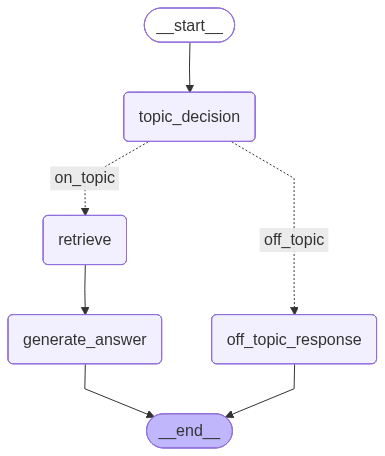

In [25]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [26]:
graph.invoke(input={
    "messages": [HumanMessage(content="Who is the owner and what are the timings?")]
})

{'messages': [HumanMessage(content='Who is the owner and what are the timings?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the provided context, there is no information about the owner of the gym. \n\nThe timings of the Peak Performance Gym are as follows:\n- Monday to Friday: 5:00 AM to 11:00 PM\n- Weekends (Saturday and Sunday): 7:00 AM to 9:00 PM\n- Closed on major national holidays\n\nHowever, members with Premium access can enter the gym 24/7, including holidays, using their key cards.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 342, 'total_tokens': 439, 'completion_time': 0.225183936, 'prompt_time': 0.028610203, 'queue_time': 0.10390694, 'total_time': 0.253794139}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_155ab82e98', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--381b2751-3d57-493a-8985-6b38d7150e07-0', usage_metadata={'input_toke

In [27]:
graph.invoke(input={
    "messages": [HumanMessage(content="What does the company Apple do?")]
})

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question!", additional_kwargs={}, response_metadata={})],
 'on_topic': 'No'}